In [619]:
# import modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import datetime

warnings.filterwarnings("ignore")

In [367]:
# load data excel file
transactions = pd.read_excel("../data/assesment_data.xlsx", sheet_name=0)
transactions.rename(columns={"ID ":"ID", "Buyer Phone": "buyer_phone", 
                             "Grand Total": "grand_total", "Buyer City": "buyer_city", 
                             "Date":"date", "Status":"status"}, inplace=True)
# drop null values (only 9/~3000 instances)
transactions.dropna(axis=0, how="any", inplace=True)
transactions['buyer_phone'] = transactions.buyer_phone.astype("int64")
transactions.head()

# delete below this line later
# fix tags in Status
mapper = {"Refunded":"refunded", "Delivered - Soum Product":"Transferred",
          "refunded":"refunded", "Transferred":"Transferred"}

transactions['status'] = transactions.status.apply(lambda x: mapper[x])

# confirm fix
# transactions.Status.value_counts()
transactions.head()

,ID,date,status,buyer_phone,buyer_city,grand_total
0,1,2025-08-19,refunded,536047743,Riyadh,10849.950
1,3,2025-08-19,refunded,555755225,Riyadh,6630.525
2,4,2025-08-19,Transferred,551540834,Abha,8122.500
3,5,2025-08-19,Transferred,558411024,Abha,12671.100
4,6,2025-08-19,Transferred,509292218,Abha,7233.300


In [267]:
# take a glance at transactions
transactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2957 entries, 0 to 2965
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   ID           2957 non-null   int64         
 1   date         2957 non-null   datetime64[ns]
 2   status       2957 non-null   object        
 3   buyer_phone  2957 non-null   int64         
 4   buyer_city   2957 non-null   object        
 5   grand_total  2957 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 161.7+ KB


In [265]:
# load data from excel file
customers = pd.read_excel("../data/assesment_data.xlsx", sheet_name=1)
customers.rename(columns={"User ID":"ID", "mobileNumber":"customer_phone"}, inplace=True)
# drop null values (only 1/~80,000 instances)
customers.dropna(axis=0, how="any", inplace=True)
customers['customer_phone'] = customers.customer_phone.astype("int64")
customers.head()

,ID,customer_phone,createdDate,lastLoginDate
0,1,556736718,01/08/2025T08:28:25.471Z,01/08/2025T08:28:34.830Z
1,2,564760303,01/08/2025T08:31:15.696Z,10/09/2025T07:44:25.074Z
2,3,530903122,01/08/2025T08:58:21.856Z,01/08/2025T08:59:35.462Z
3,4,506040253,01/08/2025T09:08:19.853Z,01/08/2025T09:09:09.052Z
4,5,531402212,01/08/2025T09:12:53.093Z,01/08/2025T09:12:59.441Z


In [268]:
# take a glance at customers
customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82851 entries, 0 to 82851
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ID              82851 non-null  int64 
 1   customer_phone  82851 non-null  int64 
 2   createdDate     82851 non-null  object
 3   lastLoginDate   82851 non-null  object
dtypes: int64(2), object(2)
memory usage: 3.2+ MB


* Prelimenary Data Quality Assessment

- No null values in either data frame (except 1 phone number)
- Data types are appropriate 
- 

Result 1: % of users who had 1+ transaction

Assumptions:
- There should be a unique 1-to-1 correspondence between phone numbers and user IDs. (turns out to be true almost)

In [186]:
# validate assumptions

customers.nunique()

ID               82852
mobileNumber     82848
createdDate      82843
lastLoginDate    82849
dtype: int64

In [187]:
# find the number of unique users
n_customers = customers.ID.nunique()

# find the number of customers who made at least one purchase
n_transactions = transactions.ID.nunique()

conversion_rate = n_transactions / n_customers
print("Conversion rate is {:.2f}%".format(conversion_rate * 100)) 

Conversion rate is 3.57%


Result 2: % of users who purchases their 2nd or 3rd transaction after a
refunded transaction vs of users who purchases their 2nd or 3rd  after transferred
one

Assumptions:
- There are either transfered transactions or refunded transactions
- The date column is sorted in ascending order

In [354]:
# validate assumptions

transactions.status.value_counts()

Transferred    1565
refunded       1392
Name: status, dtype: int64

- We can fix this problem by lumping together the entries of refunded transactions. 
- However, it is more difficult to make sense of the meaning of "Delivered - Soum Product." 
- Since we can't ask colleagues to confirm that those entries indicate items that were in fact delivered to satisfied customers, we will lump them with the "Transferred" column and hope we don't produce any bias. 

In [ ]:
# fix tags in Status
mapper = {"Refunded":"refunded", "Delivered - Soum Product":"Transferred",
          "refunded":"refunded", "Transferred":"Transferred"}

transactions['Status'] = transactions.Status.apply(lambda x: mapper[x])

# confirm fix
transactions.Status.value_counts()

Transferred    1569
refunded       1397
Name: Status, dtype: int64

In [ ]:
# group

groups = transactions.groupby(["buyer_phone"])

# number of first-time buyers who returned the device
n_refund_first_time = 0
# number of first-time buyers who accepted the device
n_accept_first_time = 0
# number of second-time buyers who returned the device in their first purchase
n_returned_after_refund = 0
# number of second-time buyers who accepted the device in their first purchase
n_returned_after_accept = 0

for buyer_phone, group in groups:
    # the first-time purchase is always at the top of the group
    status_first_purchase = group.iloc[0]['status']
    accepted = status_first_purchase == "Transferred"
    returning_customer = group.shape[0] > 1
    loyal_customer = group.shape[0] > 2
    
    # make the below loops a separate function
    
    if accepted:
        n_accept_first_time += 1
        if returning_customer:
            n_returned_after_accept += 1
    else:
        n_refund_first_time += 1
        if returning_customer:
            n_returned_after_refund +=1

In [502]:
# create new attribute to assess the behavior of customers

def get_behavior(customers, record_length = 3):
    """

    Args:
        customers (pd.DataFrame.groups): collection of data frames, one 
        for each customer who made a purchase. The purchases of a customer
        are ordered chronologically.
        
        record_length (int): number of purchases to keep track of

    Returns:
        pd.Series[(int, boolean, boolean, boolean)]: series indicating if
        the customer accepted the product he/she purchased; null if purchase
        was never made.
    """

    customers_behavior = {}
    # purchase_record = pd.Series(np.repeat(np.nan, record_length))
    
    for buyer_number, purchases in customers:
        # purchase_record = pd.Series(np.repeat(np.nan, record_length))
        purchase_record = []
        n_purchases = purchases.shape[0]            
        # if n_purchases < 3:
        #     continue
        # print(n_purchases)
        # print(purchases.status)
        accepted = purchases.status == "Transferred"
        # print(accepted)
        n_tracked = min(n_purchases, record_length)
        purchase_record[0:n_tracked] = accepted[0:n_tracked]
        # print(n_tracked)
        # print(purchase_record)
        try:
            purchase_record = purchase_record + list(np.repeat(None, record_length - n_tracked))
        except:
            print(purchase_record)
            print(np.repeat(None, record_length - n_purchases))
            print(purchase_record + list(np.repeat(None, record_length - n_tracked)))
        
        # print(purchase_record)
        # print("Next iteration ***")
        customers_behavior[buyer_number] = purchase_record
    
    return customers_behavior

In [503]:
groups = transactions.groupby(["buyer_phone"])
results = get_behavior(groups, 3)
results

{500421154: [False, None, None],
 500980006: [True, None, None],
 502118629: [False, None, None],
 502192244: [False, None, None],
 502378158: [False, None, None],
 502679041: [True, None, None],
 503779121: [False, None, None],
 504557661: [True, None, None],
 504971633: [True, None, None],
 508375678: [True, None, None],
 508383480: [False, True, None],
 508388156: [True, None, None],
 508404362: [False, None, None],
 508417788: [True, None, None],
 508434828: [False, None, None],
 508448858: [False, None, None],
 508460413: [False, True, None],
 508579577: [True, True, None],
 508621477: [False, None, None],
 508636501: [True, None, None],
 508716106: [False, None, None],
 508721049: [True, None, None],
 508787918: [False, None, None],
 508840193: [True, None, None],
 508853583: [False, None, None],
 508867125: [True, False, None],
 508873010: [True, False, True],
 508874308: [False, None, None],
 508907180: [False, True, True],
 508932586: [False, None, None],
 508934958: [True, No

In [499]:
lst = []
lst[0:2] = [False, False]
lst + [None]

[False, False, None]

In [477]:
results

{500421154: 0    False
 1      NaN
 2      NaN
 dtype: object,
 500980006: 0    False
 1      NaN
 2      NaN
 dtype: object,
 502118629: 0    False
 1      NaN
 2      NaN
 dtype: object,
 502192244: 0    False
 1      NaN
 2      NaN
 dtype: object,
 502378158: 0    False
 1      NaN
 2      NaN
 dtype: object,
 502679041: 0    False
 1      NaN
 2      NaN
 dtype: object,
 503779121: 0    False
 1      NaN
 2      NaN
 dtype: object,
 504557661: 0    False
 1      NaN
 2      NaN
 dtype: object,
 504971633: 0    False
 1      NaN
 2      NaN
 dtype: object,
 508375678: 0    False
 1      NaN
 2      NaN
 dtype: object,
 508383480: 0    False
 1      NaN
 2      NaN
 dtype: object,
 508388156: 0    False
 1      NaN
 2      NaN
 dtype: object,
 508404362: 0    False
 1      NaN
 2      NaN
 dtype: object,
 508417788: 0    False
 1      NaN
 2      NaN
 dtype: object,
 508434828: 0    False
 1      NaN
 2      NaN
 dtype: object,
 508448858: 0    False
 1      NaN
 2      NaN
 dtype: 

In [511]:
customer_597635265 = transactions.query("buyer_phone == 597635265")
n_transactions = customer_597635265.shape[0]
customer_597635265[['purchase_1', 'purchase_2', 'purchase_3']] = np.tile(results[597635265], (n_transactions, 1))
print(customer_597635265)
# print(results[597635265])

        ID                    date       status  buyer_phone    buyer_city  \
85     107 2025-08-29 00:00:00.000  Transferred    597635265       Al Baha   
1159  1425 2025-10-19 00:00:00.000     refunded    597635265  Ras Tannurah   
1981  2405 2025-11-17 11:53:00.096     refunded    597635265        Riyadh   
2958  3600 2025-12-13 12:15:59.904  Transferred    597635265        Jeddah   

      grand_total  month  day  purchase_1  purchase_2  purchase_3  
85        1598.28      8   29        True       False       False  
1159      7552.50     10   19        True       False       False  
1981      8165.25     11   17        True       False       False  
2958      3201.12     12   13        True       False       False  


In [527]:
n_transactions = (transactions.buyer_phone == 597635265).sum()
transactions.loc[transactions.buyer_phone == 597635265][['purchase_1', 'purchase_2', 'purchase_3']] = np.tile(results[597635265], (n_transactions, 1))
transactions.loc[transactions.buyer_phone == 597635265]
np.tile(results[597635265], (n_transactions, 1))

,0,1,2
0,True,False,False
1,True,False,False
2,True,False,False
3,True,False,False


In [537]:
# add new attributes
df_new = pd.DataFrame({"buyer_phone":[],"purchase_1":[], "purchase_2":[], "purchase_3":[]})

for buyer_phone, past_behavior in results.items():

    df_new = df_new.append(pd.Series([buyer_phone]+past_behavior), ignore_index=True)
# transactions.head(10)    


In [546]:
df_new.columns

Index(['buyer_phone', 'purchase_1', 'purchase_2', 'purchase_3', 0, 1, 2, 3], dtype='object')

In [549]:
df_new.iloc[:,0:4] = df_new.iloc[:,4:]
df_new.drop(columns=[0,1,2,3], inplace=True)
df_new['buyer_phone'] = df_new.buyer_phone.astype('int')
df_new

,buyer_phone,purchase_1,purchase_2,purchase_3
0,500421154.0,False,None,None
1,500980006.0,True,None,None
2,502118629.0,False,None,None
3,502192244.0,False,None,None
4,502378158.0,False,None,None
...,...,...,...,...
2133,599934906.0,True,False,None
2134,599937027.0,True,None,None
2135,599940833.0,True,None,None
2136,599976770.0,False,None,None


In [552]:
transactions.drop(columns=['purchase_1',	'purchase_2', 'purchase_3'], inplace=True)
purchase_df = transactions.merge(df_new, 'right', on='buyer_phone')
# transactions[['purchase_1',	'purchase_2', 'purchase_3']].sum()
purchase_df

,ID,date,status,buyer_phone,buyer_city,grand_total,month,day,purchase_1,purchase_2,purchase_3
0,3419,2025-12-10 12:15:59.904,refunded,500421154,Jeddah,4332.000,12,10,False,None,None
1,3064,2025-12-04 00:00:00.000,Transferred,500980006,Riyadh,5425.830,12,4,True,None,None
2,3250,2025-12-07 12:15:59.904,refunded,502118629,Khobar,30.153,12,7,False,None,None
3,3126,2025-12-05 00:00:00.000,refunded,502192244,Dammam,20795.766,12,5,False,None,None
4,3325,2025-12-08 23:15:59.616,refunded,502378158,Rafha,5033.157,12,8,False,None,None
...,...,...,...,...,...,...,...,...,...,...,...
2952,1840,2025-11-02 17:28:00.192,refunded,599934906,Rafha,17128.500,11,2,True,False,None
2953,1038,2025-10-11 00:00:00.000,Transferred,599937027,Riyadh,4354.230,10,11,True,None,None
2954,3460,2025-12-11 12:15:59.904,Transferred,599940833,Jeddah,8961.825,12,11,True,None,None
2955,873,2025-10-05 00:00:00.000,refunded,599976770,Tabuk,10830.000,10,5,False,None,None


In [553]:
# analyze the purchase behavior of our customers
purchase_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2957 entries, 0 to 2956
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   ID           2957 non-null   int64         
 1   date         2957 non-null   datetime64[ns]
 2   status       2957 non-null   object        
 3   buyer_phone  2957 non-null   int64         
 4   buyer_city   2957 non-null   object        
 5   grand_total  2957 non-null   float64       
 6   month        2957 non-null   int64         
 7   day          2957 non-null   int64         
 8   purchase_1   2957 non-null   object        
 9   purchase_2   1179 non-null   object        
 10  purchase_3   721 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(5)
memory usage: 277.2+ KB


In [561]:
# percentage of acceptance of first purchase
n1 = purchase_df.purchase_1.count()
n2 = purchase_df.purchase_2.count()
n3 = purchase_df.purchase_3.count()
purchase_df.purchase_1.sum() / n1
# percentage of acceptance of second purchase
purchase_df.purchase_2.sum() / n2
# percentage of acceptance of third purchase
purchase_df.purchase_3.sum() / n3

0.5404125803178897

In [560]:
# 
purchase_df.loc[purchase_df.purchase_3 == True].purchase_1.sum() / purchase_df.loc[purchase_df.purchase_3 == True].purchase_1.count()

0.5701357466063348

In [ ]:
# group

groups = transactions.groupby(["buyer_phone"])

# number of first-time buyers who returned the device
n_refund = 0
# number of first-time buyers who accepted the device
n_accept = 0
# number of second-time buyers who returned the device in their first purchase
n_refund_refund = 0
n_refund_accept = 0
# number of second-time buyers who accepted the device in their first purchase
n_accept_accept = 0
n_accept_refund = 0
# numbers concerning those who made 3 purchases
n_refund_refund_refund = 0
n_refund_refund_accept = 0
n_refund_accept_refund = 0
n_refund_accept_accept = 0

n_accept_accept_accept = 0
n_accept_accept_refund = 0
n_accept_refund_accept = 0
n_accept_refund_refund = 0

# use this list to create a new attribute in the dataframe
# 95% of customers make 3 or less purchases, so it is 
# sufficient to only record up to 3 purchases
n_purchases = transactions.groupby(["buyer_phone"]).ID.count().quantile(.95)
buyer_behavior = get_behavior(groups, n_purchases)

for buyer_phone, group in groups:
    # the first-time purchase is always at the top of the group
    status_first_purchase = group.iloc[0]['status']
    accepted = status_first_purchase == "Transferred"
    returning_customer = group.shape[0] > 1
    loyal_customer = group.shape[0] > 2
    
    # make the below loops a separate function
    
    if accepted:
        n_accept += 1
        if returning_customer:
            status_first_purchase = group.iloc[1]['status']
            accepted = status_first_purchase == "Transferred"
            if accepted:
                n_accept_accept += 1
                if loyal_customer:
                    status_first_purchase = group.iloc[2]['status']
                    accepted = status_first_purchase == "Transferred"
                    if accepted:
                        n_accept_accept_accept += 1
                    else:
                        n_accept_accept_refund += 1
                else: 
                    # (buyer_phone, accepted_first_order?, accepted_second_order?, accepted_third_order?)
                    # (integer, boolean | NA, boolean | NA, boolean | NA)
                    behavior = (buyer_phone, "accept_accept")
            else:
                n_accept_refund += 1
    else:
        n_refund += 1
        if returning_customer:
            n_returned_after_refund +=1
            if loyal_customer:
                

In [ ]:
returning_customer_after_refund = n_returned_after_refund / n_refund_first_time
returning_customer_after_accept = n_returned_after_accept / n_accept_first_time

print("When a customer refunds their first purchase, there is a {:.1f}% chance they will make a second purchase.".format(returning_customer_after_refund * 100))
print("When a customer accepts their first purchase, there is a {:.1f}% chance they will make a second purchase.".format(returning_customer_after_accept * 100))

When a customer refunds their first purchase, there is a 16.5% chance they will make a second purchase.
When a customer accepts their first purchase, there is a 17.2% chance they will make a second purchase.


In [ ]:
# # find p value to determine whether the difference is due to chance
# import statsmodels.api as sm

# df_old = df2.query("landing_page=='old_page'")
# df_new = df2.query("landing_page=='new_page'")

# convert_old = df_old.converted.sum() / df_old.converted.size
# convert_new = df_new.converted.sum() / df_new.converted.size
# n_old = df_old.shape[0]
# n_new = df_new.shape[0]

# convert_old, convert_new, n_old, n_new 

In [ ]:
# result = sm.stats.proportions_ztest(count=convert_old, nobs=n_old, value=0)

# z_test = result[0]
# p_value = result[1]

# z_test, p_value

Result 3: What were the top 3 cities in terms of buying in the last 10 months (please have a
graph where the x-axis is the month and the x-axis is the % of each city from total
transactions)

In [194]:
# define magic numbers
N_BEST = 3

In [369]:
# create months list
print(transactions.date.min())
print(transactions.date.max())
# create attributes for month and day of transactions (year is always 2025)
transactions['month'] = transactions.date.apply(lambda d: d.month)
transactions['day'] = transactions.date.apply(lambda d: d.day)

2025-08-19 00:00:00
2025-12-13 12:15:59.904000


In [370]:
# create a list containing the months in the data set
months = pd.Series(transactions.month.loc[transactions.month.unique()].index)
months 

0     8
1     9
2    10
3    11
4    12
dtype: int64

In [375]:
def get_proportions(df, months, top_n = N_BEST, absolute = True):
    proportions = []
    # months_repeated = []
    # assert months
    if absolute:
        for month in months:
            proportions_this_month = (df.query(f"month == {month}").buyer_city.value_counts() / df.query(f"month == {month}").count()[0]).iloc[0:top_n]
            proportions.append(proportions_this_month.sort_index())
            # months_repeated.append(month)
    else:
        for month in months:
            total_sales_cities = df.query(f"month == {month}").groupby("buyer_city")['grand_total'].sum().sort_values(ascending=False)
            proportions_this_month = (total_sales_cities / df.query(f"month == {month}").grand_total.sum()).iloc[0:top_n]
            proportions.append(proportions_this_month.sort_index())

    return proportions

In [104]:
proportion_sales_august = transactions.query("month == 8").buyer_city.value_counts() / transactions.query("month == 8").count()[0]
proportion_sales_september = transactions.query("month == 9").buyer_city.value_counts() / transactions.query("month == 9").count()[0]
proportion_sales_october = transactions.query("month == 10").buyer_city.value_counts() / transactions.query("month == 10").count()[0]
proportion_sales_november = transactions.query("month == 11").buyer_city.value_counts() / transactions.query("month == 11").count()[0]
proportion_sales_december = transactions.query("month == 12").buyer_city.value_counts() / transactions.query("month == 12").count()[0]

In [214]:
proportions = get_proportions(transactions, months)
proportions.head(1)

Al Qassim       0.095506
Ras Tannurah    0.097753
Riyadh          0.314607
Name: buyer_city, dtype: float64

In [359]:
df_proportion_sales = pd.DataFrame({"proportion":pd.concat(proportions), "month":list(np.repeat(months, N_BEST))})
df_proportion_sales['buyer_city'] = df_proportion_sales.index
df_proportion_sales.reset_index(drop=True, inplace=True)
df_proportion_sales

,proportion,month,buyer_city
0,0.088000,8,Al Qassim
1,0.128000,8,Ras Tannurah
2,0.296000,8,Riyadh
3,0.119734,9,Al Qassim
4,0.104213,9,Ras Tannurah
5,0.294900,9,Riyadh
6,0.103753,10,Al Qassim
7,0.089404,10,Ras Tannurah
8,0.273731,10,Riyadh
9,0.095506,11,Al Qassim


In [376]:
# proportion of sales in riyals (not absolute number)
proportions_riyals = get_proportions(transactions, months, absolute=False)
df_proportion_riyals = pd.DataFrame({"proportion":pd.concat(proportions_riyals), "month":list(np.repeat(months, N_BEST))})
df_proportion_riyals['buyer_city'] = df_proportion_riyals.index
df_proportion_riyals.reset_index(drop=True, inplace=True)
df_proportion_riyals

,proportion,month,buyer_city
0,0.104120,8,Ras Tannurah
1,0.290129,8,Riyadh
2,0.091770,8,Skakah
3,0.105666,9,Al Qassim
4,0.108217,9,Ras Tannurah
5,0.318622,9,Riyadh
6,0.108344,10,Al Qassim
7,0.095646,10,Ras Tannurah
8,0.279204,10,Riyadh
9,0.085700,11,Al Qassim


Text(0.5, 1.0, 'Proportion of customers in different cities')

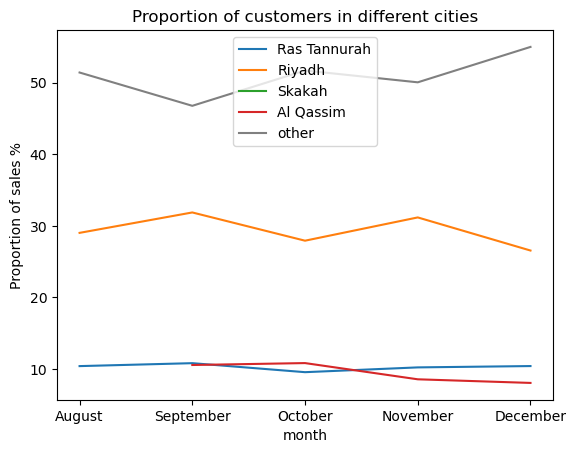

In [377]:
# calculate proportion of sales made outside the top 3 cities
other_cities = (1 - df_proportion_riyals.groupby('month')['proportion'].sum())

# make plot
sns.lineplot(x=df_proportion_riyals.month, y=df_proportion_riyals.proportion*100, hue=df_proportion_riyals.buyer_city)
plt.plot(df_proportion_riyals.month.unique(), other_cities*100, label="other", color='grey')
plt.xticks([8,9,10,11,12], labels=['August', 'September', 'October', 'November', 'December'])
plt.legend()
plt.ylabel("Proportion of sales %")
plt.title("Proportion of sales in different cities")

In [336]:
# create 3 series, one for each city
cities = df_proportion_sales.buyer_city.unique()
prop = pd.DataFrame(columns=cities, dtype='float')

for city in cities:
    prop_city = df_proportion_sales.loc[df_proportion_sales.buyer_city == city]['proportion']
    # print(prop_city)
    prop[city] = prop_city
    # print(prop_city)
prop

0     0.088000
3     0.119734
6     0.103753
9     0.095506
12    0.092308
Name: proportion, dtype: float64
1     0.128000
4     0.104213
7     0.089404
10    0.097753
13    0.097436
Name: proportion, dtype: float64
2     0.296000
5     0.294900
8     0.273731
11    0.314607
14    0.264957
Name: proportion, dtype: float64


,Al Qassim,Ras Tannurah,Riyadh
0,0.088000,NaN,NaN
3,0.119734,NaN,NaN
6,0.103753,NaN,NaN
9,0.095506,NaN,NaN
12,0.092308,NaN,NaN


Text(0.5, 1.0, 'Proportion of customers in different cities')

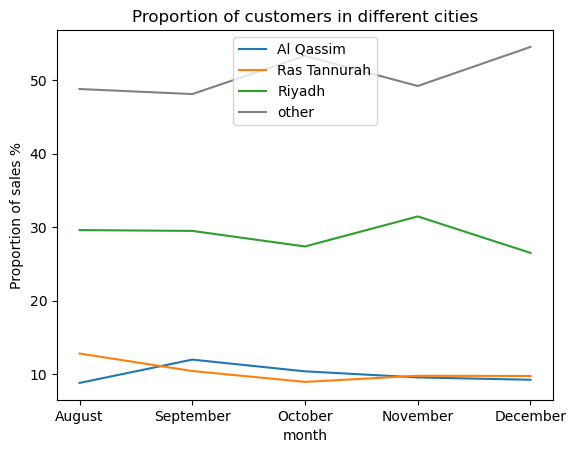

In [364]:
# calculate proportion of sales made outside the top 3 cities
other_cities = (1 - df_proportion_sales.groupby('month')['proportion'].sum())

# make plot
sns.lineplot(x=df_proportion_sales.month, y=df_proportion_sales.proportion*100, hue=df_proportion_sales.buyer_city)
plt.plot(df_proportion_sales.month.unique(), other_cities*100, label="other", color='grey')
plt.xticks([8,9,10,11,12], labels=['August', 'September', 'October', 'November', 'December'])
plt.legend()
plt.ylabel("Proportion of sales %")
plt.title("Proportion of customers in different cities")

Result 4: the average time between registration date and purchase date

In [240]:
first_purchase_df = transactions.loc[transactions.duplicated(subset="buyer_phone", keep='first')]
# first_purchase_df = first_purchase_df.reset_index() #********************************
# first_purchase_df.drop(columns=["index", "ID"])
first_purchase_df.shape

(819, 8)

In [252]:
first_purchase_df.head()

,ID,date,status,buyer_phone,buyer_city,grand_total,month,day
7,9,2025-08-21,refunded,542073979,Riyadh,4873.500,8,21
19,24,2025-08-22,refunded,552732331,Khobar,8664.000,8,22
21,26,2025-08-23,refunded,509045741,Riyadh,6630.525,8,23
33,43,2025-08-24,refunded,541899826,Riyadh,8664.000,8,24
40,53,2025-08-25,Refunded,555898433,Riyadh,775.200,8,25


In [250]:
customers.head()

,ID,buyer_phone,createdDate,lastLoginDate
0,1,556736718,01/08/2025T08:28:25.471Z,01/08/2025T08:28:34.830Z
1,2,564760303,01/08/2025T08:31:15.696Z,10/09/2025T07:44:25.074Z
2,3,530903122,01/08/2025T08:58:21.856Z,01/08/2025T08:59:35.462Z
3,4,506040253,01/08/2025T09:08:19.853Z,01/08/2025T09:09:09.052Z
4,5,531402212,01/08/2025T09:12:53.093Z,01/08/2025T09:12:59.441Z


In [292]:
joined_df = first_purchase_df.merge(customers, left_on="buyer_phone", right_on="customer_phone", how="inner", suffixes=['_purchased', '_customer'])
joined_df.head()

,ID_purchased,date,status,buyer_phone,buyer_city,grand_total,month,day,ID_customer,customer_phone,createdDate,lastLoginDate
0,24,2025-08-22,refunded,552732331,Khobar,8664.000,8,22,3106,552732331,16/08/2025T19:09:13.583Z,29/08/2025T08:11:12.617Z
1,26,2025-08-23,refunded,509045741,Riyadh,6630.525,8,23,7290,509045741,23/08/2025T10:36:49.946Z,23/08/2025T14:45:33.967Z
2,71,2025-08-27,refunded,594761696,Riyadh,2978.250,8,27,6388,594761696,22/08/2025T11:13:05.164Z,27/08/2025T10:52:16.833Z
3,100,2025-08-29,Transferred,594761696,Riyadh,2436.750,8,29,6388,594761696,22/08/2025T11:13:05.164Z,27/08/2025T10:52:16.833Z
4,113,2025-08-30,Transferred,530339323,Ras Tannurah,2049.435,8,30,6977,530339323,22/08/2025T16:12:27.088Z,22/08/2025T16:12:27.093Z


In [293]:
joined_df.shape[0] / first_purchase_df.shape[0]

0.7741147741147741

- Over a fifth of the customers who made purchases (and had their phone number recorded in transactions dataframe), could not be found on the customers dataframe
- (there phone numbers might have changed since registration and ordering, or some other explanation)

In [285]:
joined_df.iloc[0][["createdDate", "lastLoginDate"]]

createdDate      16/08/2025T19:09:13.583Z
lastLoginDate    29/08/2025T08:11:12.617Z
Name: 0, dtype: object

In [294]:
joined_df['createdDate'] = pd.to_datetime(joined_df.createdDate, infer_datetime_format=True).dt.tz_localize(None)
joined_df['lastLoginDate'] = pd.to_datetime(joined_df.lastLoginDate, infer_datetime_format=True).dt.tz_localize(None)
joined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   ID_purchased    634 non-null    int64         
 1   date            634 non-null    datetime64[ns]
 2   status          634 non-null    object        
 3   buyer_phone     634 non-null    int32         
 4   buyer_city      634 non-null    object        
 5   grand_total     634 non-null    float64       
 6   month           634 non-null    int64         
 7   day             634 non-null    int64         
 8   ID_customer     634 non-null    int64         
 9   customer_phone  634 non-null    int64         
 10  createdDate     634 non-null    datetime64[ns]
 11  lastLoginDate   634 non-null    datetime64[ns]
dtypes: datetime64[ns](3), float64(1), int32(1), int64(5), object(2)
memory usage: 61.9+ KB


In [300]:
time_until_purchase = joined_df.date - joined_df.createdDate 
joined_df['time_until_purchase'] = time_until_purchase
joined_df['time_until_purchase'].std()

Timedelta('80 days 06:01:24.069917911')

In [309]:
joined_df.time_until_purchase

0       5 days 04:50:46.417000
1     -1 days +13:23:10.054000
2       4 days 12:46:54.836000
3       6 days 12:46:54.836000
4       7 days 07:47:32.912000
                ...           
629   274 days 12:46:28.259000
630   122 days 15:51:00.956000
631    17 days 07:39:31.612000
632   279 days 05:11:08.192000
633   153 days 20:20:56.873000
Name: time_until_purchase, Length: 634, dtype: timedelta64[ns]

In [310]:
joined_df.time_until_purchase.astype('int') / (1e9 * 60 * 60 * 24)

0        5.201926
1       -0.442245
2        4.532579
3        6.532579
4        7.324686
          ...    
629    274.532272
630    122.660428
631     17.319116
632    279.216067
633    153.847880
Name: time_until_purchase, Length: 634, dtype: float64

Text(0.5, 1.0, 'Time between registration and purchase')

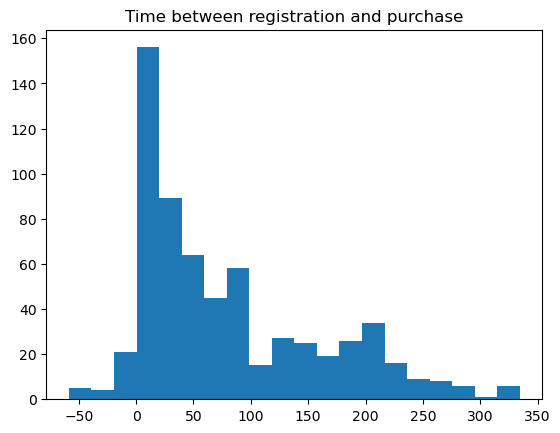

In [311]:
plt.hist(joined_df.time_until_purchase.astype('int') / (1e9 * 60 * 60 * 24), bins=20)
plt.title("Time between registration and purchase")

Some values are negative, which raises concerns about
- the quality of the data
- the consistency with which the data is inputed


In [312]:
((joined_df.time_until_purchase.astype('int') / (1e9 * 60 * 60 * 24)) < 0).sum()

25

In [314]:
joined_df.time_until_purchase.loc[((joined_df.time_until_purchase.astype('int') / (1e9 * 60 * 60 * 24)) < 0)].sort_values()

280   -59 days +10:18:57.237000
283   -58 days +02:53:56.931000
284   -57 days +12:10:07.866000
306   -56 days +04:48:25.589000
317   -54 days +09:26:05.592000
433   -29 days +21:09:19.923000
444   -27 days +23:03:42.140000
285   -26 days +05:32:48.767000
505   -22 days +10:06:02.087000
533   -18 days +03:31:21.853000
223   -13 days +09:00:16.397000
553   -12 days +07:26:14.745000
382   -10 days +20:25:56.254000
400    -7 days +21:51:32.643000
554    -6 days +13:46:14.841000
194    -1 days +03:35:31.166000
121    -1 days +05:02:16.592000
244    -1 days +05:51:34.955000
327    -1 days +07:10:07.241000
309    -1 days +12:38:09.770000
196    -1 days +13:06:41.952000
195    -1 days +13:06:41.952000
1      -1 days +13:23:10.054000
7      -1 days +15:10:46.131000
208    -1 days +22:41:12.641000
Name: time_until_purchase, dtype: timedelta64[ns]

Result 5: Give us any actionable insight from the date given, the data point should be
where the insight is coming from should be different than the previous four
analyses mentioned above, examples can be:
a. Insight: 65% of the buyers are males between 18-24
Action: We should target universities students intensively
b. Insight: 80% of the transactions are happening on the weekdays
Action: We should not do our regular advertising on the weekend and we
might use a new approach

In [566]:
purchase_df.groupby(["purchase_1", 'purchase_2'])['purchase_3'].value_counts(normalize=True)

purchase_1  purchase_2  purchase_3
False       False       True          0.678322
                        False         0.321678
            True        True          0.615894
                        False         0.384106
True        False       True          0.660517
                        False         0.339483
            True        False         0.532051
                        True          0.467949
Name: purchase_3, dtype: float64

Those who accept the first two purchases, are unusually hesitant to accept the third purchase (46% accept rate, compared with 64%+ accept rate for other kinds of customers).
Those who return an item, are likely to accept the second item the next item they purchase.

Target customers who have recently returned a purchase to make another purchase bacause: 1) we know that they are looking to buy a device, 2) we know that they are disproportionatly likely to accept the next purchase.

In [573]:
purchase_df.groupby(["purchase_1", 'purchase_2', 'purchase_3'])['ID'].count()

purchase_1  purchase_2  purchase_3
False       False       False          46
                        True           97
            True        False          58
                        True           93
True        False       False          92
                        True          179
            True        False          83
                        True           73
Name: ID, dtype: int64

In [571]:
purchase_df.groupby(["purchase_1"])['purchase_2'].value_counts(normalize=True)

purchase_1  purchase_2
False       True          0.515810
            False         0.484190
True        False         0.542348
            True          0.457652
Name: purchase_2, dtype: float64

In [568]:
purchase_df.purchase_3.value_counts(normalize=True)
pd.DataFrame.drop_duplicates()

True     0.613037
False    0.386963
Name: purchase_3, dtype: float64

In [714]:
purchase_df.columns

Index(['ID', 'date', 'status', 'buyer_phone', 'buyer_city', 'grand_total',
       'month', 'day', 'purchase_1', 'purchase_2', 'purchase_3'],
      dtype='object')

In [634]:
# create attributes: time_diff_1&2, time_diff_2&3, grand_total_diff_1, grand_total_diff_2
diffrences_df = purchase_df[['buyer_phone', 'purchase_1', 'purchase_2', 'purchase_3']].copy(deep=True)
diffrences_df.drop_duplicates('buyer_phone', inplace=True)
diffrences_df[['date_diff_1', 'date_diff_2', 'grand_total_diff_1', 'grand_total_diff_2']] = None

for buyer_phone, group in purchase_df.loc[~purchase_df.purchase_2.isna()].groupby("buyer_phone"):
    if group.shape[0] < 2:
        print('error')
        break
    # check if there are only two purchases
    if group.shape[0] == 2:
        df_temp = group[0:2][['date', 'grand_total']]
        # date and grand total of first and second purchase
        date_1, grand_total_1 = df_temp.iloc[0]
        date_2, grand_total_2 = df_temp.iloc[1]
        
        date_diff = (date_2 - date_1).total_seconds()
        grand_total_diff = grand_total_2 - grand_total_1
        
        # diffrences_df.query(f'buyer_phone == {buyer_phone}')['buyer_phone'] = buyer_phone
        # diffrences_df.query(f'buyer_phone == {buyer_phone}')['date_diff_1'] = date_diff
        # diffrences_df.query(f'buyer_phone == {buyer_phone}')['grand_total_diff_1'] = grand_total_diff
        
        diffrences_df.loc[diffrences_df.buyer_phone == buyer_phone, ['date_diff_1', 'grand_total_diff_1']] = [date_diff, grand_total_diff]
    # there is more than two purchases
    else:
        # date and grand total of first three purchases
        df_temp = group[0:3][['date', 'grand_total']]
        date_1, grand_total_1 = df_temp.iloc[0]
        date_2, grand_total_2 = df_temp.iloc[1]
        date_3, grand_total_3 = df_temp.iloc[2]
        
        date_diff_1 = (date_2 - date_1).total_seconds()
        grand_total_diff_1 = grand_total_2 - grand_total_1
        date_diff_2 = (date_3 - date_2).total_seconds()
        grand_total_diff_2 = grand_total_3 - grand_total_2
        
        # # diffrences_df.query(f'buyer_phone == {buyer_phone}')['buyer_phone'] = buyer_phone
        # diffrences_df.query(f'buyer_phone == {buyer_phone}')['date_diff_1'] = date_diff_1
        # diffrences_df.query(f'buyer_phone == {buyer_phone}')['grand_total_diff_1'] = grand_total_diff_1
        # diffrences_df.query(f'buyer_phone == {buyer_phone}')['date_diff_2'] = date_diff_2
        # diffrences_df.query(f'buyer_phone == {buyer_phone}')['grand_total_diff_2'] = grand_total_diff_2
        print([date_diff_1, date_diff_2, grand_total_diff_1, grand_total_diff_2])
        
        diffrences_df.loc[diffrences_df.buyer_phone == buyer_phone, ['date_diff_1', 'date_diff_2', 
                                                                     'grand_total_diff_1', 'grand_total_diff_2']] = [date_diff_1, date_diff_2, grand_total_diff_1, grand_total_diff_2]

diffrences_df[~diffrences_df.purchase_2.isna()].head(10)

[0.0, 518400.0, 594.7950000000001, -330.03000000000003]
[4665600.0, 473400.288, 428.4689999999996, 912.5700000000002]
[21600.0, 3600.288, 301.41599999999994, 2706.4170000000004]
[0.0, 86400.0, 0.0, -71.82]
[1085520.096, 120599.712, 2778.75, -3961.5]
[259200.0, 5184000.0, -570.0, -285.0]
[2160000.0, 4055616.0, 2028.3450000000003, 1591.1549999999997]
[417599.712, 541200.096, 566.0100000000002, 2516.834999999999]
[22199.616, 773400.096, 12760.02, -12971.775]
[86400.0, 3348000.0, 602.7750000000015, -967.5750000000007]
[255599.712, 432959.904, -3381.525, 0.0]
[1123200.0, 7340399.712, -2983.722, 3419.202]
[86400.0, 0.0, -768.9300000000003, 0.0]
[345600.0, 2332800.0, -809.4000000000001, -530.0999999999999]
[345600.0, 3246912.0, 0.0, -4219.424999999999]
[219600.288, 389759.904, 5306.985, -7182.0]
[241127.712, 2603232.0, 237.1199999999999, -3931.575]
[172800.0, 0.0, 3682.4849999999988, -4829.894999999999]
[0.0, 86400.0, -7182.0, 5158.100999999999]
[1640579.616, 3760380.288, 7956.345, 5901.15300

,buyer_phone,purchase_1,purchase_2,purchase_3,date_diff_1,date_diff_2,grand_total_diff_1,grand_total_diff_2
10,508383480,False,True,None,0.0,None,-1073.025,None
17,508460413,False,True,None,514200.096,None,1197.0,None
19,508579577,True,True,None,200519.712,None,-270.75,None
28,508867125,True,False,None,387695.808,None,-937.023,None
30,508873010,True,False,True,0.0,518400.0,594.795,-330.03
34,508907180,False,True,True,4665600.0,473400.288,428.469,912.57
39,508946919,False,False,None,3339419.616,None,-781.185,None
45,509045741,False,False,None,0.0,None,-1205.55,None
48,509092578,True,False,None,10800.0,None,1895.25,None
50,509137613,True,False,True,21600.0,3600.288,301.416,2706.417


In [579]:
counter = 0
total_sales = 0
for buyer_phone, group in transactions.groupby("buyer_phone"):
    if group.shape[0] > 1:
        counter += 1
        total_sales += group.shape[0]

counter, total_sales

(360, 1179)

In [635]:
at_least_2_df = diffrences_df.loc[diffrences_df['date_diff_1'].apply(lambda x: not pd.isna(x) and x.total_seconds != 0)]

AttributeError: 'float' object has no attribute 'total_seconds'

In [624]:
datetime.timedelta.total_seconds(diffrences_df.iloc[0, 4])

TypeError: descriptor 'total_seconds' for 'datetime.timedelta' objects doesn't apply to a 'NoneType' object

In [ ]:
datetime.timedelta.total_seconds(diffrences_df.loc[~diffrences_df.purchase_2.isna()].iloc[0, 4])

In [628]:
diffrences_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2138 entries, 0 to 2956
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   buyer_phone         2138 non-null   int64 
 1   purchase_1          2138 non-null   object
 2   purchase_2          360 non-null    object
 3   purchase_3          131 non-null    object
 4   date_diff_1         360 non-null    object
 5   date_diff_2         131 non-null    object
 6   grand_total_diff_1  360 non-null    object
 7   grand_total_diff_2  131 non-null    object
dtypes: int64(1), object(7)
memory usage: 150.3+ KB


In [633]:
pd.to_datetime(diffrences_df.loc[diffrences_df['date_diff_1'].apply(lambda x: not pd.isna(x) and x.total_seconds != 0)])

ValueError: to assemble mappings requires at least that [year, month, day] be specified: [day,month,year] is missing

Text(0.5, 1.0, 'Time between registration and purchase')

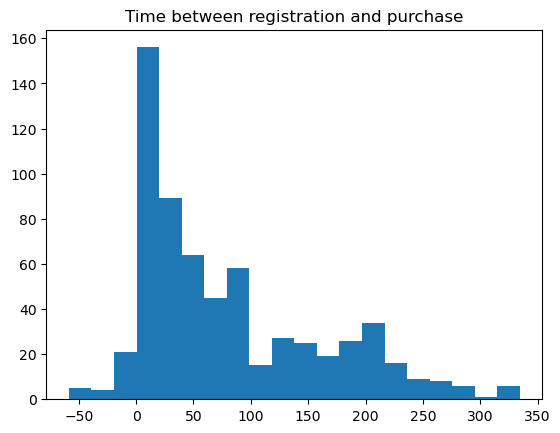

In [636]:
plt.hist(joined_df.time_until_purchase.astype('int') / (1e9 * 60 * 60 * 24), bins=20)
plt.title("Time between registration and purchase")

(array([ 7., 13., 10.,  5.,  8.,  6.,  4.,  7.,  2.,  3.,  4.,  4.,  1.,
         2.,  2.,  1.,  1.,  0.,  0.,  0.,  2.,  1.,  0.,  2.,  0.,  2.,
         1.,  0.,  0.,  0.,  3.,  3.,  0.,  0.,  1.,  1.,  2.,  3.,  0.,
         0.,  0.,  0.,  0.,  0.,  2.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.]),
 array([0.00347, 0.8530186000000001, 1.7025672000000003, 2.5521158,
        3.4016644000000005, 4.251213000000001, 5.1007616,
        5.9503102000000005, 6.799858800000001, 7.649407400000001,
        8.498956000000002, 9.348504600000002, 10.1980532, 11.0476018,
        11.897150400000001, 12.746699000000001, 13.596247600000002,
        14.445796200000002, 15.295344800000002, 16.1448934,
        16.994442000000003, 17.8439906, 18.6

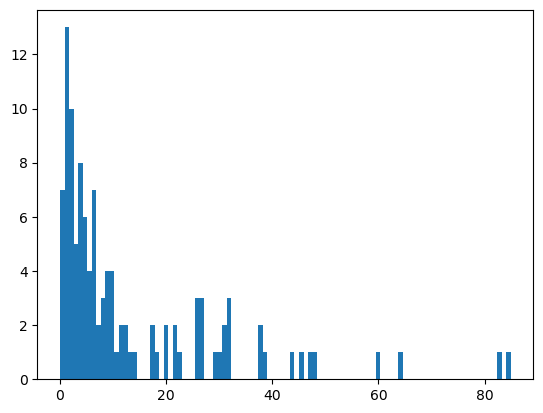

In [650]:
plt.hist(diffrences_df.date_diff_2.loc[(~diffrences_df.purchase_3.isna() & diffrences_df.date_diff_2 > 0)] / (60 * 60 * 24), bins=100)

plt.title("Number of days between second and third purchase")

In [647]:
diffrences_df.date_diff_2.count()

131

Can we make this plot more informative? 

In [654]:
# Bin edges that will be used to "cut" the data into groups
bin_edges = [diffrences_df['date_diff_1'].min(), 
             diffrences_df['date_diff_1'].quantile(0.10),
             diffrences_df['date_diff_1'].quantile(0.20),
             diffrences_df['date_diff_1'].quantile(0.30),
             diffrences_df['date_diff_1'].quantile(0.40),
             diffrences_df['date_diff_1'].quantile(0.50),
             diffrences_df['date_diff_1'].quantile(0.60),
             diffrences_df['date_diff_1'].quantile(0.70),
             diffrences_df['date_diff_1'].quantile(0.80),
             diffrences_df['date_diff_1'].quantile(0.90),
             diffrences_df['date_diff_1'].max()] 
bin_edges

[-86400.0,
 0.0,
 86400.0,
 172800.0,
 345600.0,
 506057.76,
 691200.0,
 1045703.7791999999,
 1846907.6543999997,
 2939693.9904000005,
 8770559.904]

In [667]:
# bin labels to use to name the attribute after cutting the data
bin_names = np.array([
             diffrences_df['date_diff_1'].quantile(0.10),
             diffrences_df['date_diff_1'].quantile(0.20),
             diffrences_df['date_diff_1'].quantile(0.30),
             diffrences_df['date_diff_1'].quantile(0.40),
             diffrences_df['date_diff_1'].quantile(0.50),
             diffrences_df['date_diff_1'].quantile(0.60),
             diffrences_df['date_diff_1'].quantile(0.70),
             diffrences_df['date_diff_1'].quantile(0.80),
             diffrences_df['date_diff_1'].quantile(0.90),
             diffrences_df['date_diff_1'].max()]) / (60 * 60 * 24)
bin_names = np.array(bin_names, dtype=int)
bin_names

array([  0,   1,   2,   4,   5,   8,  12,  21,  34, 101])

In [668]:
at_least_2_df = diffrences_df.loc[~diffrences_df.purchase_2.isna()]
at_least_2_df['date_diff_1_levels'] = pd.cut(at_least_2_df['date_diff_1'], bin_edges, labels=bin_names)
at_least_2_df

,buyer_phone,purchase_1,purchase_2,purchase_3,date_diff_1,date_diff_2,grand_total_diff_1,grand_total_diff_2,date_diff_1_levels
10,508383480,False,True,None,0.0,None,-1073.025,None,0
17,508460413,False,True,None,514200.096,None,1197.0,None,8
19,508579577,True,True,None,200519.712,None,-270.75,None,4
28,508867125,True,False,None,387695.808,None,-937.023,None,5
30,508873010,True,False,True,0.0,518400.0,594.795,-330.03,0
...,...,...,...,...,...,...,...,...,...
2907,598009506,False,True,None,2154420.288,None,-883.5,None,34
2922,598891216,False,True,None,7773359.616,None,-1649.466,None,101
2933,599396690,False,False,None,1698300.0,None,-2964.0,None,21
2942,599630759,False,False,None,248832.0,None,285.0,None,4


In [712]:
at_least_2_df.groupby('date_diff_1_levels')['grand_total_diff_1'].mean()

date_diff_1_levels
0     -550.411000
1       62.212909
2      375.930000
4      463.814561
5      265.369200
8     -222.379800
12     484.744031
21    -106.827500
34     368.813750
101     82.056250
Name: grand_total_diff_1, dtype: float64

In [698]:
# get counts for each rating and color
status_counts = at_least_2_df.groupby(['date_diff_1_levels', 'purchase_1']).count()['buyer_phone']
status_counts

date_diff_1_levels  purchase_1
0                   False         23
                    True          22
1                   False         19
                    True          25
2                   False          8
                    True          11
4                   False         22
                    True          19
5                   False         16
                    True          14
8                   False         15
                    True          25
12                  False         12
                    True          20
21                  False         16
                    True          20
34                  False         21
                    True          15
101                 False         19
                    True          17
Name: buyer_phone, dtype: int64

In [699]:
# get total counts for each color
status_totals = at_least_2_df.groupby('date_diff_1_levels').count()['buyer_phone']
status_totals

date_diff_1_levels
0      45
1      44
2      19
4      41
5      30
8      40
12     32
21     36
34     36
101    36
Name: buyer_phone, dtype: int64

In [700]:
# get proportions by dividing red rating counts by total # of red samples
zero_proportions = status_counts[0] / status_totals[0]
zero_proportions

purchase_1
False    0.511111
True     0.488889
Name: buyer_phone, dtype: float64

In [701]:
# do the same thing with other numbers
one_proportions = status_counts[1] / status_totals[1]
two_proportions = status_counts[2] / status_totals[2]
four_proportions = status_counts[4] / status_totals[4]
five_proportions = status_counts[5] / status_totals[5]
eight_proportions = status_counts[8] / status_totals[8]
tweleve_proportions = status_counts[12] / status_totals[12]
twentyone_proportions = status_counts[21] / status_totals[21]
thirtyfour_proportions = status_counts[34] / status_totals[34]
onehundredone_proportions = status_counts[101] / status_totals[101]

In [709]:
proportions_lists = []

for num in bin_names:
    ne = status_counts[num] / status_totals[num]
    proportions_lists.append(ne)
proportions_lists[0]

purchase_1
False    0.511111
True     0.488889
Name: buyer_phone, dtype: float64

In [ ]:
ind = np.arange(len(accepted_proportions))  # the x locations for the groups
width = 0.35       # the width of the bars
ind

In [703]:
ind_new = []
for i in range(len(ind)):
    location = ind[i]
    location_new = location + width
    ind_new.append([location, location_new])
ind_new

[[0, 0.35],
 [1, 1.35],
 [2, 2.35],
 [3, 3.35],
 [4, 4.35],
 [5, 5.35],
 [6, 6.35],
 [7, 7.35],
 [8, 8.35],
 [9, 9.35]]

([<matplotlib.axis.XTick at 0x7fed2b995700>,
 [Text(0.175, 0, '0'),
  Text(1.175, 0, '1'),
  Text(2.175, 0, '2'),
  Text(3.175, 0, '4'),
  Text(4.175, 0, '5'),
  Text(5.175, 0, '8'),
  Text(6.175, 0, '12'),
  Text(7.175, 0, '21'),
  Text(8.175, 0, '34'),
  Text(9.175, 0, '101')])

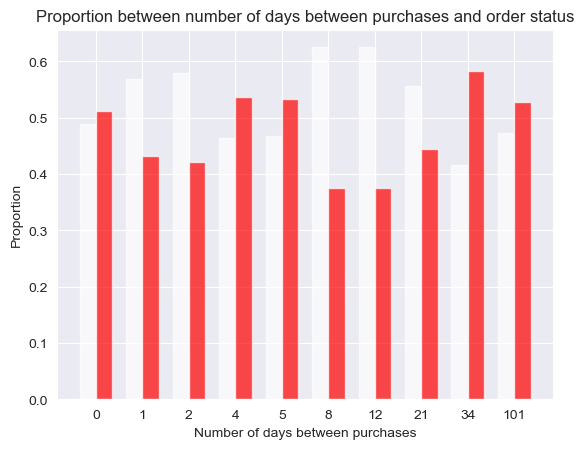

In [716]:
proportions_lists
ind_new
for i in range(len(ind_new)):
    plt.bar(ind_new[i][0], proportions_lists[i][True], width, color='w', alpha=.7, label='Accepted Order')
    plt.bar(ind_new[i][1], proportions_lists[i][False], width, color='r', alpha=.7, label='Refunded Order')
    
# # title and labels
plt.ylabel('Proportion')
plt.xlabel('Number of days between purchases')
plt.title('Proportion between number of days between purchases and order status')
locations = ind + width / 2  # xtick locations
# labels = ['3', '4', '5', '6', '7', '8', '9']  # xtick labels
labels = ['0', '1', '2', '4', '5', '8', '12', '21', '34', '101']

plt.xticks(locations, labels)

# # legend
# plt.legend()


In [ ]:
sns.set_style('darkgrid')
# plot bars
accepted_bars = plt.bar(ind, accepted_proportions, width, color='r', alpha=.7, label='Accepted Order')
returned_bars = plt.bar(ind + width, refunded_proportions, width, color='w', alpha=.7, label='Refunded Order')

# # title and labels
plt.ylabel('Proportion')
plt.xlabel('Number of days between purchases')
plt.title('Proportion between number of days between purchases and order status')
locations = ind + width / 2  # xtick locations
# labels = ['3', '4', '5', '6', '7', '8', '9']  # xtick labels
labels = ['0', '1', '2', '4', '5', '8', '12', '21', '34', '101']

plt.xticks(locations, labels)

# # legend
plt.legend()


In [692]:
# original********************************************************************************************************************************
# get total counts for each color
status_totals = at_least_2_df.groupby('purchase_1').count()['buyer_phone']
status_totals

purchase_1
False    171
True     189
Name: buyer_phone, dtype: int64

In [693]:
# get counts for each rating and color
status_counts = at_least_2_df.groupby(['purchase_1', 'date_diff_1_levels']).count()['buyer_phone']
status_counts

purchase_1  date_diff_1_levels
False       0                     23
            1                     19
            2                      8
            4                     22
            5                     16
            8                     15
            12                    12
            21                    16
            34                    21
            101                   19
True        0                     22
            1                     25
            2                     11
            4                     19
            5                     14
            8                     25
            12                    20
            21                    20
            34                    15
            101                   17
Name: buyer_phone, dtype: int64

In [694]:
# get proportions by dividing red rating counts by total # of red samples
accepted_proportions = status_counts[True] / status_totals[True]
accepted_proportions

date_diff_1_levels
0      0.116402
1      0.132275
2      0.058201
4      0.100529
5      0.074074
8      0.132275
12     0.105820
21     0.105820
34     0.079365
101    0.089947
Name: buyer_phone, dtype: float64

In [695]:
# get proportions by dividing red rating counts by total # of red samples
refunded_proportions = status_counts[False] / status_totals[False]
refunded_proportions

date_diff_1_levels
0      0.134503
1      0.111111
2      0.046784
4      0.128655
5      0.093567
8      0.087719
12     0.070175
21     0.093567
34     0.122807
101    0.111111
Name: buyer_phone, dtype: float64

In [696]:
ind = np.arange(len(accepted_proportions))  # the x locations for the groups
width = 0.35       # the width of the bars
ind

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

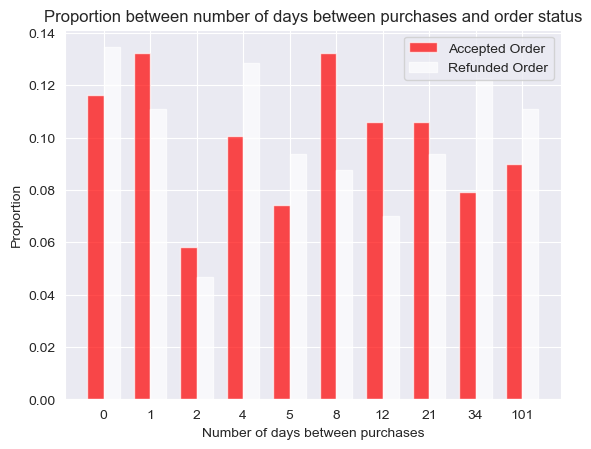

In [697]:
sns.set_style('darkgrid')
# plot bars
accepted_bars = plt.bar(ind, accepted_proportions, width, color='r', alpha=.7, label='Accepted Order')
returned_bars = plt.bar(ind + width, refunded_proportions, width, color='w', alpha=.7, label='Refunded Order')

# # title and labels
plt.ylabel('Proportion')
plt.xlabel('Number of days between purchases')
plt.title('Proportion between number of days between purchases and order status')
locations = ind + width / 2  # xtick locations
# labels = ['3', '4', '5', '6', '7', '8', '9']  # xtick labels
labels = ['0', '1', '2', '4', '5', '8', '12', '21', '34', '101']

plt.xticks(locations, labels)

# # legend
plt.legend()
